In [1]:
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
def get_labels_mat(filename) -> list:
    mat_data = loadmat(f"./data/{filename}")
    label = mat_data["class_vector_train"].reshape(
        -1,
    )
    label = [item for sublist in label for item in sublist]
    return label


def get_parameters_mat(filename) -> pd.DataFrame:
    mat_data = loadmat(f"./data/{filename}")
    parameters = mat_data["training_set"]
    return pd.DataFrame(parameters.T)


def get_parameter_names_mat(filename) -> list:
    mat_data = loadmat("./data/paremeterNames.mat")
    names = mat_data["parameterNames"].reshape(
        -1,
    )
    names = [name for sublist in names for name in sublist]
    return names


def get_dataset(
    labels_file: str, params_file: str, names_file: str = "paremeterNames.mat"
) -> pd.DataFrame:
    labels = get_labels_mat(labels_file)
    parameters = get_parameters_mat(params_file)
    parameters.columns = get_parameter_names_mat(names_file)
    parameters["label"] = labels
    return parameters

### Get data

In [3]:
df = get_dataset(
    labels_file="class_vector_train_ref.mat", 
    params_file="training_set_ref.mat"
)

print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (200000, 259)


,BIO@atp_c,BIO@pyr_c,BIO@nad_c,BIO@g6p_c,BIO@oaa_c,BIO@f6p_c,BIO@nadph_c,BIO@nh4_c,BIO@o2_c,BIO@r5p_c,...,D_LAC@feri_m,D_LAC@lac_m,SUCCt2r@suc_c,MALt2r@mal_c,CITt2m@mal_c,CITt2m@cit_m,CITt2m@mal_m,CITt2m@cit_c,PFK@amp_c,label
0,0.457634,0.014440,0.058212,0.676883,0.341359,0.662601,0.558494,0.469465,0.379688,0.031882,...,0.310612,0.176318,0.750574,0.835077,0.636952,0.805681,0.314653,0.601644,0.442062,s
1,0.011809,0.879388,0.003459,0.746891,0.306732,0.324433,0.790872,0.561433,0.601143,0.729455,...,0.260641,0.480122,0.828887,0.774984,0.793254,0.111233,0.174306,0.035144,0.432545,s
2,0.150170,0.442691,0.029388,0.930178,0.904467,0.690296,0.083225,0.292097,0.122153,0.097039,...,0.780362,0.548510,0.591525,0.579699,0.168482,0.214867,0.430102,0.757192,0.281138,s
3,0.241337,0.108236,0.874900,0.908554,0.945598,0.204189,0.396873,0.474224,0.738103,0.958655,...,0.998683,0.015408,0.362024,0.127115,0.230577,0.996991,0.195371,0.013773,0.316083,s
4,0.357361,0.179095,0.737178,0.371373,0.562450,0.809965,0.920162,0.750900,0.623332,0.356794,...,0.298213,0.555471,0.611591,0.020826,0.543747,0.459455,0.110901,0.838803,0.561902,s


In [4]:
df['label'].value_counts(normalize=True).round(4)

label
ns    0.5287
s     0.4713
Name: proportion, dtype: float64

### FFC

In [5]:
mat_data = loadmat("./data/ccXTR_ref.mat")

In [29]:
enzyme = mat_data['commonEnzAct'][0][0][2][0][0][0]
print(f'Enzyme: {enzyme}')

commonEnz = mat_data['commonEnzAct'][0][0][3][0][0]
commonEnz = [item for sublist in commonEnz for item in sublist]
commonEnz = [item[0] for item in commonEnz]
print(f'Common enzymes: {commonEnz}')

allEnzymes = mat_data['commonEnzAct'][0][0][4][0][0]
allEnzymes = [item for sublist in allEnzymes for item in sublist]
allEnzymes = [item[0] for item in allEnzymes]
print(f'Number of all enzymes: {len(allEnzymes)}')

commonConCoeff = mat_data['commonEnzAct'][0][0][0][0][0]
allConCoeff = mat_data['commonEnzAct'][0][0][1][0][0]

Enzyme: XTR
Common enzymes: ['HXK', 'PGI', 'TPI', 'ZWF', 'ATPM', 'ADK', 'NDR', 'PDA', 'XTR', 'XRI', 'XDH', 'XK']
Number of all enzymes: 86


In [30]:
commonConCoeff = pd.DataFrame(commonConCoeff[:, 0, :], columns=commonEnz)
print(f'Original shape of commonConCoeff: {commonConCoeff.shape}')

Original shape of commonConCoeff: (200000, 12)


In [51]:
(HXK_cc < 0).sum() / HXK_cc.shape[0]

0.47043984677511447

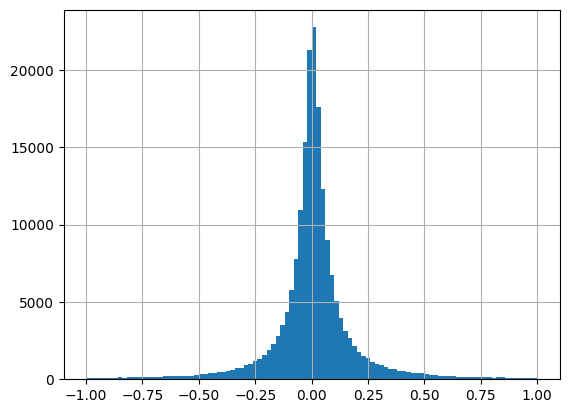

In [47]:
HXK_cc = commonConCoeff[(commonConCoeff['HXK'] >= -1) & (commonConCoeff['HXK'] <= 1)]['HXK']
HXK_cc.hist(bins=100)    
plt.show()
